In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import kagglehub
import torchvision.transforms as T
from torchvision.utils import make_grid
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm

In [3]:
from torch import nn
from torch.nn.utils.parametrizations import spectral_norm
import torch.nn.functional as F

In [4]:
to_tensor = T.ToTensor()

def load_image(path):
    return to_tensor(Image.open(path))


def show_images(imgs):
    # imgs is a tensor of shape: B x C x H x W
    grid = make_grid(imgs.detach().cpu(), nrow=4, padding=10, pad_value=1)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.gcf().set_figwidth(8)
    plt.show()

In [5]:
class Monet(Dataset):
    def __init__(self, img_size=256):
        self.data_path = kagglehub.dataset_download(
            "dimitreoliveira/monet-paintings-jpg-berkeley")
        self.img_names = os.listdir(self.data_path)
        self.img_names = list(filter(lambda s: os.path.isfile(os.path.join(self.data_path, s)), self.img_names))

        # resize images to lower resolution
        print("Image size:", img_size)
        if img_size == 256:
            self.resized_data_path = self.data_path
        else:
            self.resized_data_path = os.path.join(self.data_path, f"resized_{img_size}")

        print("Saving resized images...")
        for img_name in tqdm(self.img_names):
            resized_path = os.path.join(self.resized_data_path, img_name)
            if os.path.exists(resized_path):
                continue

            # resize to specified img size
            orig_img_path = os.path.join(self.data_path, img_name)
            with Image.open(orig_img_path) as img:
                resized_img = img.resize((img_size, img_size))
                # save
                os.makedirs(os.path.dirname(resized_path), exist_ok=True)
                resized_img.save(resized_path)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        return load_image(os.path.join(self.resized_data_path, self.img_names[index]))


Data downloaded already


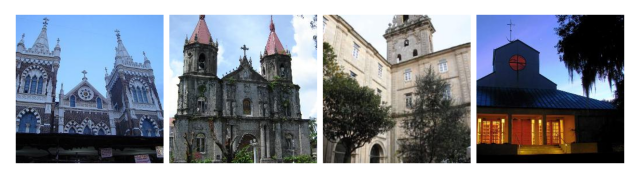

In [6]:
import requests
import zipfile

class LSUNChurchSubset(Dataset):
    def __init__(self, data_dir):

        self.data_path = os.path.abspath(os.path.join(data_dir, "lsun-subset"))
        os.makedirs(self.data_path, exist_ok=True)

        # download if not already downloaded
        if len(os.listdir(self.data_path)) == 2000:
            print("Data downloaded already")
        else:
            print("Downloading data")

            # get zip file from Adam's Duke Box
            zip_url = "https://duke.app.box.com/index.php?rm=box_download_shared_file&shared_name=0af4hdn4muor7rkickcrtp8ppk41n7dk&file_id=f_1713403290181"
            response = requests.get(zip_url, stream=True)
            response.raise_for_status()

            # write zip file to a temp file
            with open("temp.zip", "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)

            # extract files
            with zipfile.ZipFile("temp.zip", "r") as zip_ref:
                zip_ref.extractall(data_dir)

            # delete temp zip file
            os.remove("temp.zip")

        # get image names
        self.img_names = os.listdir(self.data_path)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        return load_image(os.path.join(self.data_path, self.img_names[index]))


loader = DataLoader(LSUNChurchSubset("lsun-church-subset"), batch_size=4, shuffle=True)
imgs = next(iter(loader))
show_images(imgs)

In [7]:
monet = Monet()
lsun = LSUNChurchSubset("lsun-church-subset")

batch_size = 2
monet_loader = DataLoader(monet, batch_size=batch_size, shuffle=True)
lsun_loader = DataLoader(lsun, batch_size=batch_size, shuffle=True)

Image size: 256
Saving resized images...


100%|██████████| 1193/1193 [00:00<00:00, 15892.16it/s]

Data downloaded already


In [8]:
progressive_resolutions = [8, 16, 32, 64, 128, 256]
num_epochs_per_stage = 5  # how long should we train at each stage/resolution?

class GeneratorResidualBlock(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(n_channels, n_channels, kernel_size=3),
            nn.InstanceNorm2d(n_channels),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(n_channels, n_channels, kernel_size=3),
            nn.InstanceNorm2d(n_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return x + self.layers(x)

class ConvBlock(nn.Module):
  def __init__(self, features_in, features_out, kernel_size, stride=1):
    super().__init__()
    self.layers = nn.Sequential(
        nn.ReflectionPad2d((kernel_size - 1) // 2),
        nn.Conv2d(features_in, features_out, kernel_size, stride=stride),
        nn.InstanceNorm2d(features_out),
        nn.ReLU()
    )
  def forward(self, x):
    return self.layers(x)


class FromRGBBlock(nn.Module):
  def __init__(self, resolution_out, features_out, kernel_size=1, stride=1):
    super().__init__()
    self.resolution_out = resolution_out
    self.conv = ConvBlock(3, features_out, kernel_size=kernel_size, stride=stride)

  def forward(self, x):
    x = F.interpolate(x, size=(self.resolution_out, self.resolution_out), mode='bilinear', align_corners=False)
    # convert to correct number of features
    return self.conv(x)


class ToRGBBlock(nn.Module):
  def __init__(self, features_in, kernel_size=1):
    super().__init__()
    self.layers = nn.Sequential(
        nn.ReflectionPad2d((kernel_size-1) // 2),
        nn.Conv2d(features_in, 3, kernel_size),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.layers(x)

In [9]:
class ProgGenerator(nn.Module):
    def __init__(self, step=0, alpha=0.0):
        super().__init__()

        self.step = step
        self.alpha = alpha

        # progressive downsampling layers
        self.downsample_blocks = nn.ModuleList([
            ConvBlock(64, 128, kernel_size=3, stride=2),
            ConvBlock(128, 256, kernel_size=3, stride=2),
        ])

        # residual blocks
        self.residual_blocks = nn.Sequential(
            *[GeneratorResidualBlock(256) for i in range(6)]
        )

        # progressive upsampling layers
        self.upsample_blocks = nn.ModuleList([
            nn.Sequential(
              nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # ConvTranspose2d with stride=2 doubles the spatial dimensions.
              nn.InstanceNorm2d(128),
              nn.ReLU()
            ),
            nn.Sequential(
              nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
              nn.InstanceNorm2d(64),
              nn.ReLU()
            )
        ])

        # from-RGB and to-RGB layers for each step
        self.from_rgb_layers = nn.ModuleList([
            FromRGBBlock(resolution_out=64, features_out=256, kernel_size=1),  # step 0
            FromRGBBlock(resolution_out=128, features_out=128, kernel_size=1),  # step 1
            FromRGBBlock(resolution_out=256, features_out=64, kernel_size=7),  # step 2
        ])
        self.to_rgb_layers = nn.ModuleList([
            ToRGBBlock(256, kernel_size=1),
            ToRGBBlock(128, kernel_size=1),
            ToRGBBlock(64, kernel_size=1)
        ])

    def forward(self, input): # x = input img, step = current resolution step (4x4 -> 8x8 -> 1024x1024), alpha = factor for resolution-blending
        # print("input shape", input.shape)

        # apply correct fromRGB layer
        x = self.from_rgb_layers[self.step](input)
        # print("after from rgb", x.shape)

        downsample_blocks_to_use = self.downsample_blocks[len(self.downsample_blocks)-self.step:len(self.downsample_blocks)]
        for i, block in enumerate(downsample_blocks_to_use):
          # on the first block, blend with what we had before when we weren't using that block
          if i == 0:
            # note that self.step isn't 0 here, because if it was, this for loop wouldn't run
            prev_x = self.from_rgb_layers[self.step-1](input)
            x = block(x)
            x = self.alpha * x + (1 - self.alpha) * prev_x
          else:
            x = block(x)

        # print("after downsample", x.shape)

        x = self.residual_blocks(x)
        # print("after residual", x.shape)

        upsample_blocks_to_use = self.upsample_blocks[:self.step]
        for block in upsample_blocks_to_use:
          prev_x = x.clone()
          x = block(x)
          # print(x.shape)
        # print("after upsample", x.shape)

        # convert to rgb
        x = self.to_rgb_layers[self.step](x)

        # if first step, no previous, so just return x
        if self.step == 0:
          return x

        # for other steps, interpolate between previous and current
        # convert prev to rgb
        prev_x = self.to_rgb_layers[self.step-1](prev_x)
        # convert prev to correct resolution
        prev_x = F.interpolate(prev_x, scale_factor=2, mode='bilinear', align_corners=False)
        # interpolate
        return self.alpha * x + (1 - self.alpha) * prev_x

g = ProgGenerator(step=2)
imgs = next(iter(lsun_loader))
g(imgs).shape

torch.Size([2, 3, 256, 256])

In [10]:
class ProgDiscriminator(nn.Module):
    def __init__(self, step=0, alpha=0.0):
        super().__init__()

        self.step = step
        self.alpha = alpha

        # from-RGB layers for each res
        self.from_rgb_layers = nn.ModuleList([
            FromRGBBlock(resolution_out=64, features_out=128, kernel_size=1),  # step 0
            FromRGBBlock(resolution_out=128, features_out=64, kernel_size=1),  # step 1
            # on step 2, conv0 will process the RGB image, no need to project to higher feature space
        ])

        self.blocks = nn.ModuleList([
            self._create_discriminator_block(3, 64),
            self._create_discriminator_block(64, 128),
            self._create_discriminator_block(128, 256),
            self._create_discriminator_block(256, 512),
        ])

        # final Conv -> Sigmoid layer
        self.final_layer = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=3, stride=1),
            nn.Flatten(1),
            nn.Sigmoid()
        )

    def _create_discriminator_block(self, features_in, features_out):
        return nn.Sequential(
            spectral_norm(nn.Conv2d(features_in, features_out, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, input):

        # print(f"Input shape: {input.shape}")

        # from RGB:
        if self.step < 2:
          x = self.from_rgb_layers[self.step](input)
        else:
          x = input
        # print(f"After from_rgb_layers[{self.step}]: {x.shape}")

        # discriminator blocks up to curr res:
        start_block_index = len(self.blocks)-2-self.step
        blocks_to_use = self.blocks[start_block_index:len(self.blocks)]
        for i, block in enumerate(blocks_to_use):
            # on entry, blend with what we were doing before
            if i == 0 and self.step >= 1:
                prev_x = self.from_rgb_layers[self.step-1](input)
                x = block(x)
                # print("boo", x.shape, prev_x.shape)
                x = self.alpha * x + (1 - self.alpha) * prev_x
            else:
                x = block(x)
            # print(f"After block: {x.shape}")

        # Final layer to output size 1 (use sigmoid)
        return self.final_layer(x)


d = ProgDiscriminator(step=2)
imgs = next(iter(lsun_loader))
d(imgs).shape

torch.Size([2, 196])

In [11]:
# # Let's check if it works:

import torch
# from torchsummary import summary
import torch.nn.functional as F

###### initial test ########
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
g = ProgGenerator(step=2)
d = ProgDiscriminator(step=2)

imgs = next(iter(lsun_loader))
print("Start Generator:")
fake_imgs = g(imgs)
print("Start Discriminator:")
d_output = d(fake_imgs)
print("output", d_output.shape)

Start Generator:
Start Discriminator:
output torch.Size([2, 196])


In [12]:
# Hyperparameters
num_epochs = 10
lr = 0.0002
lambda_cycle = 10
lambda_identity = 5

class FakeImageBuffer():
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.img_history = []

    def swap(self, mini_batch):
        swapped_mini_batch = []
        for img in mini_batch.data:
            img = torch.unsqueeze(img, 0).detach()
            if len(self.img_history) < self.max_size:
                self.img_history.append(img)
                swapped_mini_batch.append(img)
            else:
                if torch.rand(1) > 0.5:
                    # don't swap
                    swapped_mini_batch.append(img)
                else:
                    # pick random prev img to swap with
                    i = torch.randint(0, self.max_size, (1,))
                    img_from_history = self.img_history[i].clone()
                    # history image might be a different resolution, resize it before swapping
                    img_from_history = F.interpolate(img_from_history, size=img.shape[-2:], mode="bilinear", align_corners=False)
                    swapped_mini_batch.append(img_from_history)
                    self.img_history[i] = img
        return torch.cat(swapped_mini_batch)
    

# utility functions to save progress to an image file every once in a while
# so we don't have to stop the training to see what's going on

def imshow_on_axis(img, ax):
    np_img = img.detach().permute(1,2,0).cpu().numpy()
    ax.axis("off")
    ax.imshow(np_img)

def save_progress_file(real_x, real_y, fake_x, fake_y, cycle_x, cycle_y):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
    axes[0][0].set_title("photo -->")
    imshow_on_axis(real_x[0], axes[0][0])
    axes[0][1].set_title("monet")
    imshow_on_axis(fake_y[0], axes[0][1])
    axes[0][2].set_title("--> photo")
    imshow_on_axis(cycle_x[0], axes[0][2])
    axes[1][0].set_title("monet -->")
    imshow_on_axis(real_y[0], axes[1][0])
    axes[1][1].set_title("photo")
    imshow_on_axis(fake_x[0], axes[1][1])
    axes[1][2].set_title("--> monet")
    imshow_on_axis(cycle_y[0], axes[1][2])
    fig.tight_layout()
    fig.savefig("progress.png")
    plt.close()  # don't print temp figures to the notebok

In [13]:
from torch.optim import Adam

class ProgressiveGANTrainer:
    def __init__(self, generator_g, generator_f, discriminator_x, discriminator_y, device, lr=0.0002):
        self.generator_g = generator_g.to(device)
        self.generator_f = generator_f.to(device)
        self.discriminator_x = discriminator_x.to(device)
        self.discriminator_y = discriminator_y.to(device)
        self.device = device

        # Loss functions
        self.adversarial_loss = nn.MSELoss()
        self.cycle_loss = nn.L1Loss()
        self.identity_loss = nn.L1Loss()

        # Optimizers
        self.optimizer_g = Adam(list(self.generator_g.parameters(
        )) + list(self.generator_f.parameters()), lr=lr, betas=(0.5, 0.999))
        self.optimizer_dx = Adam(
            self.discriminator_x.parameters(), lr=lr, betas=(0.5, 0.999))
        self.optimizer_dy = Adam(
            self.discriminator_y.parameters(), lr=lr, betas=(0.5, 0.999))

        # Fake image buffers
        self.fake_x_history = FakeImageBuffer()
        self.fake_y_history = FakeImageBuffer()

        self.loss_g_history = []
        self.loss_dx_history = []
        self.loss_dy_history = []

    def train(self, dataloaders, n_epochs, step, fixed_alpha=None):

        # Update models for current step
        self.generator_g.step = step
        self.generator_f.step = step
        self.discriminator_x.step = step
        self.discriminator_y.step = step

        lsun_loader, monet_loader = dataloaders
        batches_in_epoch = min(len(monet_loader), len(lsun_loader))

        for epoch in range(n_epochs):
            for b, (real_x, real_y) in enumerate(zip(lsun_loader, monet_loader)):
                real_x = real_x.to(self.device)
                real_y = real_y.to(self.device)
                # note - no need to resize input images, because the models will do this themselves

                # Update alpha
                batch_count = (epoch * batches_in_epoch) + b
                total_batch_count = n_epochs * batches_in_epoch
                alpha = fixed_alpha if fixed_alpha is not None else batch_count / total_batch_count

                self.generator_g.alpha = alpha
                self.generator_f.alpha = alpha
                self.discriminator_x.alpha = alpha
                self.discriminator_y.alpha = alpha

                # Train Generators
                self.optimizer_g.zero_grad()
                fake_y = self.generator_g(real_x)
                pred_fake_y = self.discriminator_y(fake_y)
                loss_g_adv = self.adversarial_loss(
                    pred_fake_y, torch.ones_like(pred_fake_y))
                fake_x = self.generator_f(real_y)
                pred_fake_x = self.discriminator_x(fake_x)
                loss_f_adv = self.adversarial_loss(
                    pred_fake_x, torch.ones_like(pred_fake_x))

                # Cycle Consistency Loss
                cycle_x = self.generator_f(fake_y)  # X -> Y -> X
                real_x_resized = F.interpolate(
                    real_x, size=cycle_x.shape[-2:], mode='bilinear', align_corners=False)  # added this line (Ellie)
                loss_cycle_x = self.cycle_loss(cycle_x, real_x_resized)

                cycle_y = self.generator_g(fake_x)  # Y -> X -> Y
                real_y_resized = F.interpolate(
                    real_y, size=cycle_y.shape[-2:], mode='bilinear', align_corners=False)  # added this line (Ellie)
                loss_cycle_y = self.cycle_loss(cycle_y, real_y_resized)

                # Identity Loss
                identity_x = self.generator_f(real_x)
                real_x_resized = F.interpolate(
                    real_x, size=identity_x.shape[-2:], mode='bilinear', align_corners=False)  # added this line (Ellie)
                loss_id_x = self.identity_loss(identity_x, real_x_resized)

                identity_y = self.generator_g(real_y)
                real_y_resized = F.interpolate(
                    real_y, size=identity_y.shape[-2:], mode='bilinear', align_corners=False)  # added this line (Ellie)
                loss_id_y = self.identity_loss(identity_y, real_y_resized)

                # Total Generator Loss
                loss_g = (loss_g_adv + loss_f_adv + lambda_cycle * (loss_cycle_x + loss_cycle_y) +
                          lambda_identity * (loss_id_x + loss_id_y))
                loss_g.backward()
                self.optimizer_g.step()

                # Train Discriminators
                self.optimizer_dx.zero_grad()
                pred_real_x = self.discriminator_x(real_x)
                loss_dx_real = self.adversarial_loss(
                    pred_real_x, torch.ones_like(pred_real_x))
                # fake_x = self.fake_x_history.swap(fake_x)
                pred_fake_x = self.discriminator_x(fake_x.detach())
                loss_dx_fake = self.adversarial_loss(
                    pred_fake_x, torch.zeros_like(pred_fake_x))
                loss_dx = (loss_dx_real + loss_dx_fake) * 0.5
                loss_dx.backward()
                self.optimizer_dx.step()

                self.optimizer_dy.zero_grad()
                pred_real_y = self.discriminator_y(real_y)
                loss_dy_real = self.adversarial_loss(
                    pred_real_y, torch.ones_like(pred_real_y))
                # fake_y = self.fake_y_history.swap(fake_y)
                pred_fake_y = self.discriminator_y(fake_y.detach())
                loss_dy_fake = self.adversarial_loss(
                    pred_fake_y, torch.zeros_like(pred_fake_y))
                loss_dy = (loss_dy_real + loss_dy_fake) * 0.5
                loss_dy.backward()
                self.optimizer_dy.step()

                # save loss values
                self.loss_g_history.append(loss_g.item())
                self.loss_dx_history.append(loss_dx.item())
                self.loss_dy_history.append(loss_dy.item())

                if b % 25 == 0:
                    save_progress_file(real_x, real_y, fake_x,
                                       fake_y, cycle_x, cycle_y)

                print(f"Step {step} | alpha {alpha:.4f} | Epoch [{epoch+1}/{n_epochs}] | Batch [{b+1}/{batches_in_epoch}] "
                      f"| Loss G: {loss_g.item():.4f} | Loss DX: {loss_dx.item():.4f} | Loss DY: {loss_dy.item():.4f}")

            # Save models
            torch.save(self.generator_g.state_dict(),
                       f"progressive_generator_g_step{step}.pth")
            torch.save(self.generator_f.state_dict(),
                       f"progressive_generator_f_step{step}.pth")
            torch.save(self.discriminator_x.state_dict(),
                       f"progressive_discriminator_x_step{step}.pth")
            torch.save(self.discriminator_y.state_dict(),
                       f"progressive_discriminator_y_step{step}.pth")
            
            # Save loss history
            with open("loss_g.txt", "w") as f:
                f.write(str(self.loss_g_history))
            with open("loss_dx.txt", "w") as f:
                f.write(str(self.loss_dx_history))
            with open("loss_dy.txt", "w") as f:
                f.write(str(self.loss_dy_history))
            


In [196]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
generator_g = ProgGenerator().to(device)  # original img -> monet
generator_f = ProgGenerator().to(device)  # monet -> cifar

discriminator_x = ProgDiscriminator().to(device)  # For real
discriminator_y = ProgDiscriminator().to(device)  # For Monet

In [197]:
# Create the trainer
trainer = ProgressiveGANTrainer(generator_g, generator_f, discriminator_x, discriminator_y, device)

In [198]:
trainer.train(dataloaders=(lsun_loader, monet_loader), n_epochs=4, step=0, fixed_alpha=0.0)

Step 0 | alpha 0.0000 | Epoch [1/4] | Batch [1/597] | Loss G: 9.4472 | Loss DX: 0.2528 | Loss DY: 0.2501
Step 0 | alpha 0.0000 | Epoch [1/4] | Batch [2/597] | Loss G: 10.8406 | Loss DX: 0.2425 | Loss DY: 0.2636
Step 0 | alpha 0.0000 | Epoch [1/4] | Batch [3/597] | Loss G: 9.6293 | Loss DX: 0.3066 | Loss DY: 0.2702
Step 0 | alpha 0.0000 | Epoch [1/4] | Batch [4/597] | Loss G: 8.6008 | Loss DX: 0.2588 | Loss DY: 0.2590
Step 0 | alpha 0.0000 | Epoch [1/4] | Batch [5/597] | Loss G: 7.6136 | Loss DX: 0.2347 | Loss DY: 0.2466
Step 0 | alpha 0.0000 | Epoch [1/4] | Batch [6/597] | Loss G: 7.1845 | Loss DX: 0.2386 | Loss DY: 0.2364
Step 0 | alpha 0.0000 | Epoch [1/4] | Batch [7/597] | Loss G: 8.5309 | Loss DX: 0.2310 | Loss DY: 0.2728
Step 0 | alpha 0.0000 | Epoch [1/4] | Batch [8/597] | Loss G: 7.4107 | Loss DX: 0.2096 | Loss DY: 0.2513
Step 0 | alpha 0.0000 | Epoch [1/4] | Batch [9/597] | Loss G: 7.1175 | Loss DX: 0.2622 | Loss DY: 0.2527
Step 0 | alpha 0.0000 | Epoch [1/4] | Batch [10/597] |

In [199]:
trainer.train(dataloaders=(lsun_loader, monet_loader), n_epochs=4, step=1)

Step 1 | alpha 0.0000 | Epoch [1/4] | Batch [1/597] | Loss G: 3.5301 | Loss DX: 0.1321 | Loss DY: 0.1388
Step 1 | alpha 0.0004 | Epoch [1/4] | Batch [2/597] | Loss G: 3.6546 | Loss DX: 0.1356 | Loss DY: 0.1582
Step 1 | alpha 0.0008 | Epoch [1/4] | Batch [3/597] | Loss G: 4.6416 | Loss DX: 0.1234 | Loss DY: 0.2170
Step 1 | alpha 0.0013 | Epoch [1/4] | Batch [4/597] | Loss G: 3.4613 | Loss DX: 0.2315 | Loss DY: 0.2107
Step 1 | alpha 0.0017 | Epoch [1/4] | Batch [5/597] | Loss G: 3.5075 | Loss DX: 0.2660 | Loss DY: 0.2690
Step 1 | alpha 0.0021 | Epoch [1/4] | Batch [6/597] | Loss G: 2.9363 | Loss DX: 0.1824 | Loss DY: 0.2341
Step 1 | alpha 0.0025 | Epoch [1/4] | Batch [7/597] | Loss G: 2.8853 | Loss DX: 0.2239 | Loss DY: 0.2538
Step 1 | alpha 0.0029 | Epoch [1/4] | Batch [8/597] | Loss G: 3.5192 | Loss DX: 0.2870 | Loss DY: 0.2173
Step 1 | alpha 0.0034 | Epoch [1/4] | Batch [9/597] | Loss G: 2.9821 | Loss DX: 0.2067 | Loss DY: 0.2153
Step 1 | alpha 0.0038 | Epoch [1/4] | Batch [10/597] | 

In [200]:
trainer.train(dataloaders=(lsun_loader, monet_loader), n_epochs=4, step=1, fixed_alpha=1.0)

Step 1 | alpha 1.0000 | Epoch [1/4] | Batch [1/597] | Loss G: 3.5408 | Loss DX: 0.2171 | Loss DY: 0.1904
Step 1 | alpha 1.0000 | Epoch [1/4] | Batch [2/597] | Loss G: 3.4558 | Loss DX: 0.1720 | Loss DY: 0.1958
Step 1 | alpha 1.0000 | Epoch [1/4] | Batch [3/597] | Loss G: 2.9257 | Loss DX: 0.2473 | Loss DY: 0.2576
Step 1 | alpha 1.0000 | Epoch [1/4] | Batch [4/597] | Loss G: 2.7278 | Loss DX: 0.1998 | Loss DY: 0.2383
Step 1 | alpha 1.0000 | Epoch [1/4] | Batch [5/597] | Loss G: 3.1293 | Loss DX: 0.2404 | Loss DY: 0.2077
Step 1 | alpha 1.0000 | Epoch [1/4] | Batch [6/597] | Loss G: 3.0439 | Loss DX: 0.2138 | Loss DY: 0.1779
Step 1 | alpha 1.0000 | Epoch [1/4] | Batch [7/597] | Loss G: 2.6081 | Loss DX: 0.2114 | Loss DY: 0.1693
Step 1 | alpha 1.0000 | Epoch [1/4] | Batch [8/597] | Loss G: 3.7304 | Loss DX: 0.1830 | Loss DY: 0.1709
Step 1 | alpha 1.0000 | Epoch [1/4] | Batch [9/597] | Loss G: 3.0490 | Loss DX: 0.1971 | Loss DY: 0.2326
Step 1 | alpha 1.0000 | Epoch [1/4] | Batch [10/597] | 

In [201]:
trainer.train(dataloaders=(lsun_loader, monet_loader), n_epochs=4, step=2)

Step 2 | alpha 0.0000 | Epoch [1/4] | Batch [1/597] | Loss G: 3.0878 | Loss DX: 0.1996 | Loss DY: 0.2032
Step 2 | alpha 0.0004 | Epoch [1/4] | Batch [2/597] | Loss G: 3.2560 | Loss DX: 0.1641 | Loss DY: 0.3026
Step 2 | alpha 0.0008 | Epoch [1/4] | Batch [3/597] | Loss G: 4.0846 | Loss DX: 0.2197 | Loss DY: 0.2854
Step 2 | alpha 0.0013 | Epoch [1/4] | Batch [4/597] | Loss G: 2.9777 | Loss DX: 0.2002 | Loss DY: 0.1918
Step 2 | alpha 0.0017 | Epoch [1/4] | Batch [5/597] | Loss G: 3.7583 | Loss DX: 0.2744 | Loss DY: 0.3434
Step 2 | alpha 0.0021 | Epoch [1/4] | Batch [6/597] | Loss G: 3.0697 | Loss DX: 0.2221 | Loss DY: 0.1294
Step 2 | alpha 0.0025 | Epoch [1/4] | Batch [7/597] | Loss G: 2.8970 | Loss DX: 0.1833 | Loss DY: 0.2180
Step 2 | alpha 0.0029 | Epoch [1/4] | Batch [8/597] | Loss G: 2.9343 | Loss DX: 0.1519 | Loss DY: 0.1573
Step 2 | alpha 0.0034 | Epoch [1/4] | Batch [9/597] | Loss G: 3.4051 | Loss DX: 0.2528 | Loss DY: 0.2604
Step 2 | alpha 0.0038 | Epoch [1/4] | Batch [10/597] | 

In [202]:
trainer.train(dataloaders=(lsun_loader, monet_loader), n_epochs=4, step=2, fixed_alpha=1.0)

Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [1/597] | Loss G: 3.0836 | Loss DX: 0.2219 | Loss DY: 0.2975
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [2/597] | Loss G: 2.5177 | Loss DX: 0.2732 | Loss DY: 0.3057
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [3/597] | Loss G: 2.5183 | Loss DX: 0.2545 | Loss DY: 0.2374
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [4/597] | Loss G: 2.5790 | Loss DX: 0.2454 | Loss DY: 0.2265
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [5/597] | Loss G: 2.7866 | Loss DX: 0.2249 | Loss DY: 0.2315
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [6/597] | Loss G: 2.6023 | Loss DX: 0.2323 | Loss DY: 0.2830
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [7/597] | Loss G: 2.4677 | Loss DX: 0.1966 | Loss DY: 0.2566
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [8/597] | Loss G: 3.8048 | Loss DX: 0.2197 | Loss DY: 0.2026
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [9/597] | Loss G: 2.1379 | Loss DX: 0.2165 | Loss DY: 0.2355
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [10/597] | 

In [216]:
trainer.train(dataloaders=(lsun_loader, monet_loader), n_epochs=4, step=2, fixed_alpha=1.0)

Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [1/597] | Loss G: 2.9982 | Loss DX: 0.2595 | Loss DY: 0.2341
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [2/597] | Loss G: 3.0111 | Loss DX: 0.1711 | Loss DY: 0.1986
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [3/597] | Loss G: 3.2898 | Loss DX: 0.1940 | Loss DY: 0.2006
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [4/597] | Loss G: 2.3872 | Loss DX: 0.1815 | Loss DY: 0.2188
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [5/597] | Loss G: 3.3555 | Loss DX: 0.1733 | Loss DY: 0.2432
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [6/597] | Loss G: 2.9105 | Loss DX: 0.2015 | Loss DY: 0.1927
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [7/597] | Loss G: 2.9813 | Loss DX: 0.2319 | Loss DY: 0.2111
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [8/597] | Loss G: 3.3368 | Loss DX: 0.2199 | Loss DY: 0.2409
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [9/597] | Loss G: 3.5217 | Loss DX: 0.2438 | Loss DY: 0.1825
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [10/597] | 

In [224]:
trainer.train(dataloaders=(lsun_loader, monet_loader), n_epochs=4, step=2, fixed_alpha=1.0)

Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [1/597] | Loss G: 3.9893 | Loss DX: 0.2464 | Loss DY: 0.1434
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [2/597] | Loss G: 2.9916 | Loss DX: 0.1690 | Loss DY: 0.1557
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [3/597] | Loss G: 3.3152 | Loss DX: 0.1520 | Loss DY: 0.2402
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [4/597] | Loss G: 3.8721 | Loss DX: 0.2092 | Loss DY: 0.2308
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [5/597] | Loss G: 2.9282 | Loss DX: 0.2111 | Loss DY: 0.2039
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [6/597] | Loss G: 3.3347 | Loss DX: 0.1617 | Loss DY: 0.1613
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [7/597] | Loss G: 2.9061 | Loss DX: 0.3059 | Loss DY: 0.1998
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [8/597] | Loss G: 3.2171 | Loss DX: 0.2048 | Loss DY: 0.2007
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [9/597] | Loss G: 3.4769 | Loss DX: 0.1834 | Loss DY: 0.1262
Step 2 | alpha 1.0000 | Epoch [1/4] | Batch [10/597] | 

Loss Curve

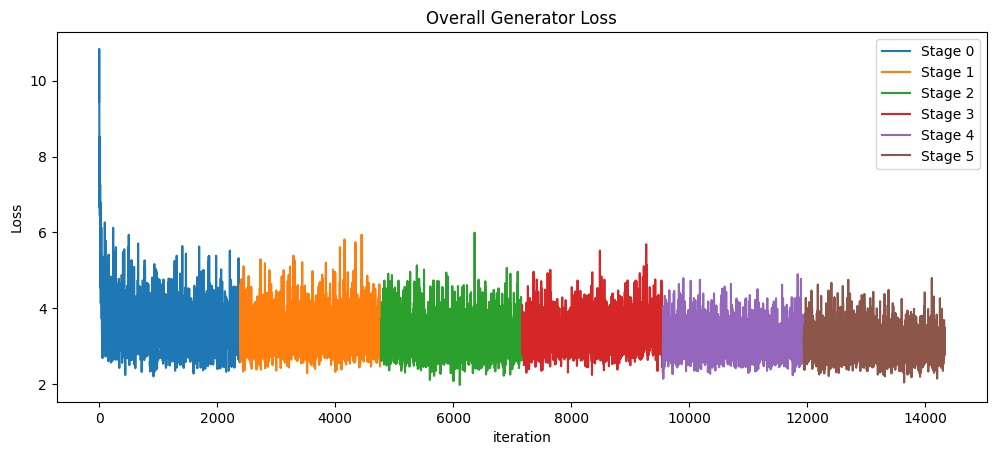

In [46]:
import json

with open("loss_g.txt") as f:
    loss_g = json.load(f)
    iteration = [i for i in range(len(loss_g))]

iter_per_stage = 4 * len(monet_loader)

for stage in range(6):
    start = iter_per_stage * stage
    end = start + iter_per_stage
    plt.plot(iteration[start:end], loss_g[start:end], label=f"Stage {stage}")

plt.title(f"Overall Generator Loss")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("iteration")
plt.gcf().set_figwidth(12)

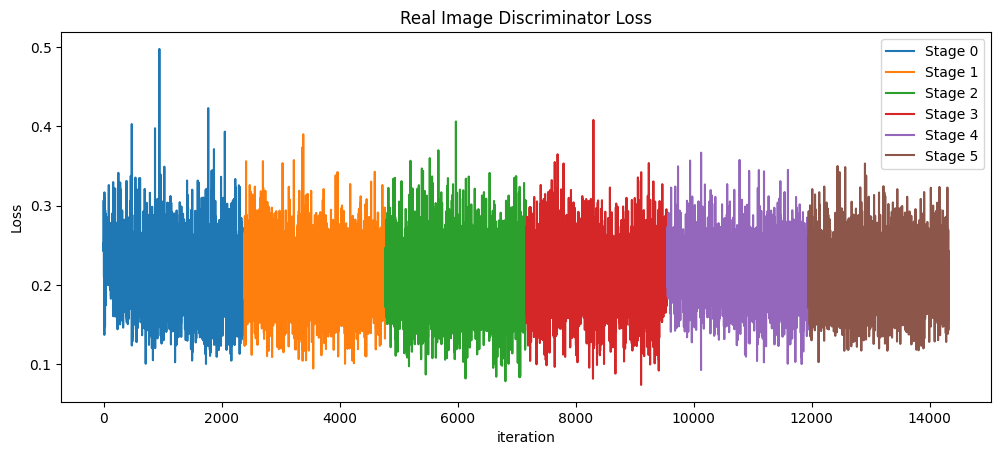

In [44]:
import json

with open("loss_dx.txt") as f:
    loss_dx = json.load(f)
    iteration = [i for i in range(len(loss_dx))]

iter_per_stage = 4 * len(monet_loader)

for stage in range(6):
    start = iter_per_stage * stage
    end = start + iter_per_stage
    plt.plot(iteration[start:end], loss_dx[start:end], label=f"Stage {stage}")

plt.title(f"Real Image Discriminator Loss")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("iteration")
plt.gcf().set_figwidth(12)

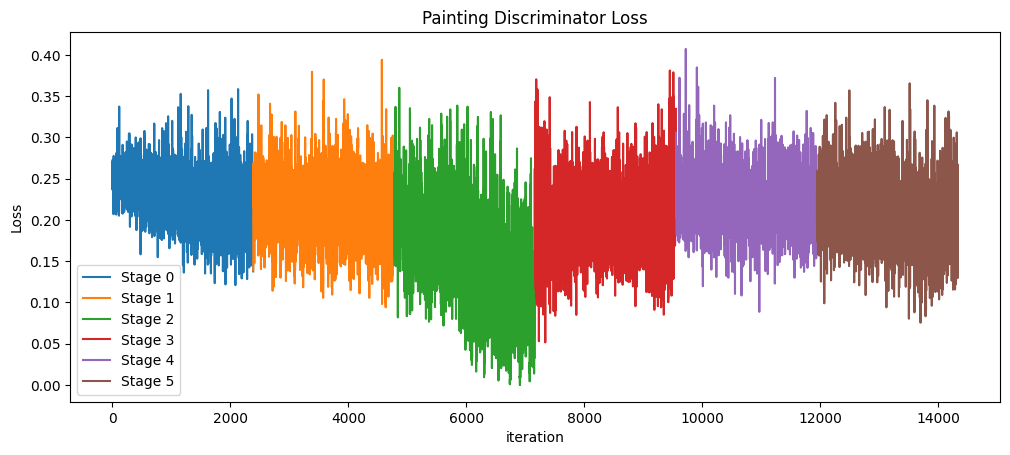

In [45]:
import json

with open("loss_dy.txt") as f:
    loss_dy = json.load(f)
    iteration = [i for i in range(len(loss_dy))]

iter_per_stage = 4 * len(monet_loader)

for stage in range(6):
    start = iter_per_stage * stage
    end = start + iter_per_stage
    plt.plot(iteration[start:end], loss_dy[start:end], label=f"Stage {stage}")

plt.title(f"Painting Discriminator Loss")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("iteration")
plt.gcf().set_figwidth(12)

Load models from save

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
generator_g = ProgGenerator(step=2, alpha=1).to(device)  # original img -> monet
generator_g.load_state_dict(torch.load("progressive_generator_g_step2.pth", weights_only=True))
generator_f = ProgGenerator(step=2, alpha=1).to(device)  # monet -> real img
generator_f.load_state_dict(torch.load("progressive_generator_f_step2.pth", weights_only=True))

discriminator_x = ProgDiscriminator(step=2, alpha=1).to(device)  # For real
discriminator_x.load_state_dict(torch.load("progressive_discriminator_x_step2.pth", weights_only=True))
discriminator_y = ProgDiscriminator(step=2, alpha=1).to(device)  # For Monet
discriminator_y.load_state_dict(torch.load("progressive_discriminator_y_step2.pth", weights_only=True))

<All keys matched successfully>

Test them

LSUN Images


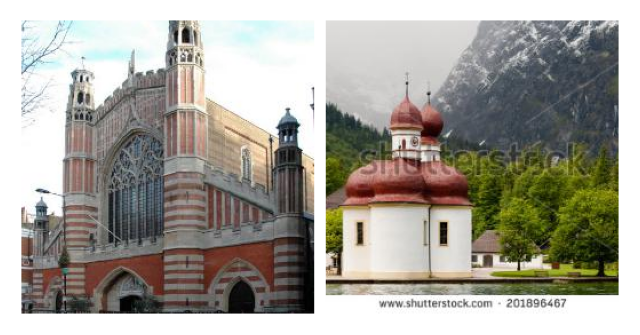

Generated Monet-style Images


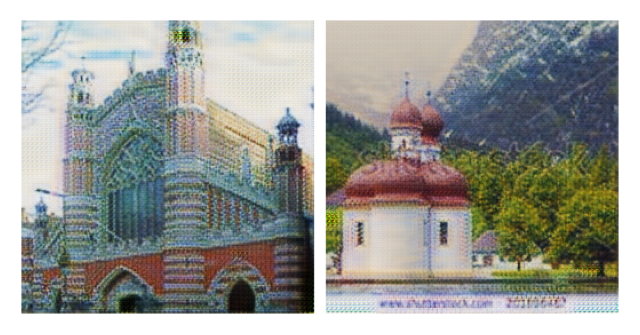

Reconstructed LSUN Images


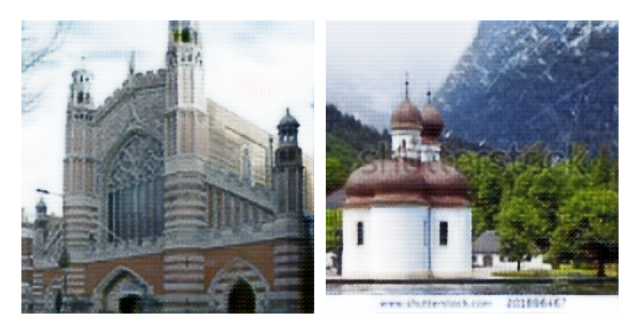

In [27]:
# now let's test our cyclegan after training to see if it actually works:

real_x  = next(iter(lsun_loader))
real_x = real_x.cuda()

fake_y = generator_g(real_x).detach()
reconstructed_x = generator_f(fake_y).detach()

fake_y = fake_y.cpu()
reconstructed_x = reconstructed_x.cpu()

n_to_show = 2  # less than or equal to batch size
print("LSUN Images")
show_images(real_x[:n_to_show].cpu())
print("Generated Monet-style Images")
show_images(fake_y[:n_to_show])
print("Reconstructed LSUN Images")
show_images(reconstructed_x[:n_to_show])